---
### Imports

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from typing import Tuple, Union, Type


---
### Data Loading and prep

In [31]:
# Load the training data
raw_training_data = pd.read_pickle(r"/content/training_data_v1.0.pkl")

In [32]:
#eliminate rows woth missing values in the policies
print("Number of rows before dropping missing values: ", len(raw_training_data))
nona_training_data = raw_training_data.dropna(subset=['C', 'E', 'G', 'S'])
print("Number of rows after dropping missing values: ", len(nona_training_data))

Number of rows before dropping missing values:  50644
Number of rows after dropping missing values:  48048


In [33]:
# Get the unique countries in the dataset
countries = nona_training_data.location.unique()
#Define the feature columns
feat_columns = ['C', 'E', 'G', 'S']
#Empty df to append the cleaned data country by country
nozero_training_data = pd.DataFrame()

# Here we remove the first rows for each country where all the features are zero
# This is done to remove the initial period where the policies were not yet implemented
for country in countries:
    temp = nona_training_data.loc[nona_training_data['location'] == country]
    temp = temp.reset_index(drop=True)
    first_non_zero_index = temp.loc[(temp[feat_columns] != 0).any(axis=1)].index[0]
    filtered_data = temp.iloc[first_non_zero_index:]
    nozero_training_data = pd.concat([nozero_training_data, filtered_data], ignore_index=True)

In [34]:
#Preparing data for the model
feat_policy_columns = ['C', 'E', 'G', 'S']
feat_totals = ['total_cases', 'total_deaths']
location = ['location']

target_cases = ['weekly_cases']
target_deaths = ['weekly_deaths']

model_data = nozero_training_data[location + feat_policy_columns + feat_totals + target_cases + target_deaths].copy()

#scaler = MinMaxScaler()
# model_data[feat_policy_columns] = scaler.fit_transform(model_data[feat_policy_columns])

In [35]:
temp = model_data.loc[model_data.location == 'Spain']['weekly_cases']
import plotly.express as px
fig = px.line(temp, y='weekly_cases', title='New Cases in Spain Over Time')
fig.show()

---
### Training phase

In [ ]:
# Function to create sequences per country
def create_sequences_per_country(df, countries, feature_columns, seq_length):
    X_list, y_list = [], []

    for country in countries:
        country_data = df[df["location"] == country].drop(columns=["location"]).reset_index(drop=True)
        features = country_data[feature_columns].values
        target = country_data["new_cases"].values

        X, y = [], []
        for i in range(len(features) - seq_length):
            X.append(features[i : i + seq_length])
            y.append(target[i + seq_length])

        X_list.append(np.array(X))
        y_list.append(np.array(y))

    return np.vstack(X_list), np.hstack(y_list)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the last time step output
        return out

In [ ]:
class COVIDTimeSeriesDataset(Dataset):
    def __init__(self, df, countries, feature_columns, seq_length):
        """
        Args:
            df (pd.DataFrame): The full dataset containing all countries' data.
            countries (list): List of country names to include.
            feature_columns (list): List of feature column names.
            seq_length (int): Number of time steps per sequence.
        """
        # Generate sequences using the provided function
        X, y = create_sequences_per_country(df, countries, feature_columns, seq_length)

        # Convert to PyTorch tensors
        self.X = torch.tensor(X, dtype=torch.float32)  # Shape: (num_samples, seq_length, num_features)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # Shape: (num_samples, 1)

    def __len__(self):
        """Return the number of samples"""
        return len(self.X)

    def __getitem__(self, idx):
        """Return one sample (X sequence and corresponding y)"""
        return self.X[idx], self.y[idx]
    def get_number_features(self):
        """Return the number of features"""
        return self.X.shape[2]


In [ ]:
def create_dataloaders(dataset, train_split=0.8, batch_size=32):
    """Creates sequential DataLoaders for training and testing"""
    # countries = df["location"].unique().tolist()  # Get all unique countries

    # Create dataset
    # dataset = COVIDTimeSeriesDataset(df, countries, feature_columns, seq_length)

    # Split into train/test using time order
    train_size = int(len(dataset) * train_split)
    # Ensure that the split is sequential
    train_dataset = torch.utils.data.Subset(dataset, range(train_size))  # First 80%
    test_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))  # Last 20%

    # DataLoader (no shuffle for sequential ordering)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
batch_size = 32

dataset = COVIDTimeSeriesDataset(df=model_data, countries=countries,
                                 feature_columns=feat_policy_columns+feat_totals, seq_length=14)
train_loader, test_loader = create_dataloaders(dataset=dataset,batch_size=batch_size)

In [ ]:
# Model initialization
input_size = dataset.get_number_features()  # Number of features
hidden_size = 32
num_layers = 1

model = RNNModel(input_size, hidden_size, num_layers)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)  # RNN output
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

In [ ]:
# Model parameters
input_size = dataset.get_number_features()  # Number of features
hidden_size = 64
num_layers = 2
output_size = 1  # Predicting one value (e.g., next time step)

# Initialize model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()  # For regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()  # Reset gradients
        y_pred = model(X_batch)  # Forward pass
        loss = criterion(y_pred, y_batch)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete!")


Epoch [1/20], Loss: 2960119169.9462
Epoch [2/20], Loss: 2959835260.3413
Epoch [3/20], Loss: 2959552808.9649
Epoch [4/20], Loss: 2959271799.2958
Epoch [5/20], Loss: 2958992614.1894
Epoch [6/20], Loss: 2958714634.4956
Epoch [7/20], Loss: 2958439394.7562
Epoch [8/20], Loss: 2958166565.3967
Epoch [9/20], Loss: 2957908527.3801
Epoch [10/20], Loss: 2957638625.3972
Epoch [11/20], Loss: 2957364341.9657
Epoch [12/20], Loss: 2957092844.8316
Epoch [13/20], Loss: 2956828194.1578
Epoch [14/20], Loss: 2956567616.9306
Epoch [15/20], Loss: 2956916606.9582
Epoch [16/20], Loss: 2956124266.4580
Epoch [17/20], Loss: 2956024279.1218
Epoch [18/20], Loss: 2955591032.9083
Epoch [19/20], Loss: 2955802588.3032
Epoch [20/20], Loss: 2956741175.9724
Training complete!


In [ ]:
model_data.shape

(46891, 9)

In [ ]:
X.shape

torch.Size([46275, 14, 6])

---
### Testing only one country

---
#### data

In [17]:
spain_data = model_data.loc[model_data.location == 'Spain']
spain_data = spain_data[['C', 'E', 'G', 'S', 'weekly_deaths', 'weekly_cases']]

In [19]:
fig = px.line(spain_data, x=spain_data.index, y='weekly_cases', title='Weekly Cases in Spain')
fig.update_layout(width=600, height=300)  # Set width to 600px and height to 300px
fig.show()



In [20]:
# # Define the columns to scale
# columns_to_scale = ['C', 'E', 'G', 'S', 'new_cases']  # Replace with your subset of columns
# #leave out target cases without normalization
# spain_data['target'] = spain_data['new_cases'].copy()
# # Initialize the scaler
# scaler = MinMaxScaler()

# # Scale only the selected columns
# spain_data[columns_to_scale] = scaler.fit_transform(spain_data[columns_to_scale])
# spain_data[['target']] = scaler.fit_transform(spain_data[['target']])

In [21]:
def create_sequences(data, target_column, feature_columns, seq_length=3):
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Get the sequence of features (past `seq_length` days)
        X_seq = data[feature_columns].iloc[i: i + seq_length].values  # Shape: (seq_length, num_features)
        X.append(X_seq)

        # Get the target for the next time step (new_cases)
        y.append(data[target_column].iloc[i + seq_length])  # Shape: (1,)

    return np.array(X), np.array(y)

In [64]:
def scale_data(df: pd.DataFrame, feature_columns: list, target_column: Union[list, str],
               scaler: Union[MinMaxScaler, StandardScaler]) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Scales the feature and target columns using the specified scaler and prepares the data for sequence modeling.

    Args:
        df (pd.DataFrame): The input DataFrame containing features and target columns.
        feature_columns (list): List of feature column names to be scaled.
        target_column (Union[list, str]): Name (or list of names) of the target column(s) to be scaled.
        scaler (Union[Type[MinMaxScaler], Type[StandardScaler]]): The scaler class to be used for normalization.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: A tuple containing:
            - y_train (np.ndarray): Log-transformed target values for the training set.
            - y_test (np.ndarray): Log-transformed target values for the test set.
            - X_train (np.ndarray): Scaled feature sequences for the training set.
            - X_test (np.ndarray): Scaled feature sequences for the test set.
    """

    scaler_X = scaler
    scaler_y = scaler
    # Scale the features (excluding the target)
    features = df[feature_columns]  # All features excluding the target
    features_scaled = scaler_X.fit_transform(features)

    # Scale the target
    target = df[target_column].values.reshape(-1, 1)
    target_scaled = scaler_y.fit_transform(target)


    scaled_features_df = pd.DataFrame(features_scaled, columns=feature_columns)
    scaled_target_df = pd.DataFrame(target_scaled, columns=[target_column]).rename(columns={'weekly_cases':'target'})

    scaled_data = pd.concat([scaled_features_df, scaled_target_df], axis=1)

    scaled_data[target_column] = target_scaled.flatten()  # Add scaled target to the dataset
    # Now create sequences using the scaled data
    X_spain, y_spain = create_sequences(data=scaled_data, target_column=target_column,
                                    feature_columns=feature_columns, seq_length=30)


    train_size = int(len(X_spain) * 1)
    X_train, X_test = X_spain[:train_size], X_spain[train_size:]
    y_train, y_test = y_spain[:train_size], y_spain[train_size:]

    # y_train = np.log1p(y_train)
    # y_test = np.log1p(y_test)

    print("Training data shape:", X_train.shape, y_train.shape)
    print("Testing data shape:", X_test.shape, y_test.shape)
    return y_train, y_test, X_train, X_test



In [25]:
feature_columns = ['C', 'E', 'G', 'S', 'weekly_deaths']#, 'weekly_cases']  # Update with actual feature names
target_column = "weekly_cases"


# Initialize scaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

y_train, y_test, X_train, X_test = scale_data(df=spain_data, feature_columns=feature_columns,
                                    target_column=target_column, scaler=MinMaxScaler())

Training data shape: (834, 30, 5) (834,)
Testing data shape: (209, 30, 5) (209,)


In [64]:
# # Assuming your dataset `spain_data` contains the features and target
# feature_columns = ['C', 'E', 'G', 'S', 'weekly_deaths']#, 'weekly_cases']  # Update with actual feature names
# target_column = "weekly_cases"


# # Initialize scaler
# scaler_X = MinMaxScaler()
# scaler_y = MinMaxScaler()

# # Scale the features (excluding the target)
# features = spain_data[feature_columns]  # All features excluding the target
# features_scaled = scaler_X.fit_transform(features)

# # Scale the target
# target = spain_data[target_column].values.reshape(-1, 1)
# target_scaled = scaler_y.fit_transform(target)


# scaled_features_df = pd.DataFrame(features_scaled, columns=feature_columns)
# scaled_target_df = pd.DataFrame(target_scaled, columns=[target_column]).rename(columns={'weekly_cases':'target'})

# scaled_data = pd.concat([scaled_features_df, scaled_target_df], axis=1)

# scaled_data[target_column] = target_scaled.flatten()  # Add scaled target to the dataset
# # Now create sequences using the scaled data
# X_spain, y_spain = create_sequences(data=scaled_data, target_column=target_column,
#                                     feature_columns=feature_columns, seq_length=30)


# train_size = int(len(X_spain) * 0.8)
# X_train, X_test = X_spain[:train_size], X_spain[train_size:]
# y_train, y_test = y_spain[:train_size], y_spain[train_size:]

# y_train = np.log1p(y_train)
# y_test = np.log1p(y_test)

# print("Training data shape:", X_train.shape, y_train.shape)
# print("Testing data shape:", X_test.shape, y_test.shape)



Training data shape: (834, 30, 5) (834,)
Testing data shape: (209, 30, 5) (209,)


In [65]:
# from sklearn.preprocessing import MinMaxScaler

# # Define feature and target columns
# feature_columns = ['C', 'E', 'G', 'S', 'new_cases']  # Update with actual feature names
# target_column = "new_cases"

# # Create sequences before scaling
# X_spain, y_spain = create_sequences(data=spain_data, target_column=target_column,
#                                     feature_columns=feature_columns, seq_length=21)

# # Initialize scalers
# scaler_X = MinMaxScaler(feature_range=(0, 1))
# scaler_y = MinMaxScaler(feature_range=(0, 1))

# # Reshape X_spain to 2D (for fitting the scaler), scale, then reshape back to 3D
# num_samples, seq_length, num_features = X_spain.shape
# X_spain_scaled = scaler_X.fit_transform(X_spain.reshape(-1, num_features)).reshape(num_samples, seq_length, num_features)

# # Scale the target values
# y_spain_scaled = scaler_y.fit_transform(y_spain.reshape(-1, 1)).flatten()  # Keep 1D structure

# # Train-test split (80-20)
# train_size = int(len(X_spain) * 0.8)
# X_train, X_test = X_spain_scaled[:train_size], X_spain_scaled[train_size:]
# y_train, y_test = y_spain_scaled[:train_size], y_spain_scaled[train_size:]


---
#### Pytorch

In [72]:
class StackedLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=2, output_size=1):
        super(StackedLSTM, self).__init__()
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        # self.relu = nn.ReLU()  # To prevent vanishing gradients

    def forward(self, x):
        out, _ = self.lstm(x)  # Get LSTM output
        out = out[:, -1, :]  # Take last timestep's output
        out = self.fc(out)  # Fully connected layer
        # return self.relu(out)  # Apply ReLU activation
        return out

In [73]:
def init_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

In [68]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size= X_train.shape[2]
hidden_size=100
num_layers= 2
output_size=1
# Define model
model = StackedLSTM(input_size=input_size, hidden_size=hidden_size,
                    num_layers=num_layers, output_size=output_size).to(device)
model.apply(init_weights)
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

print(device)
print(model)  # Print model architecture


cuda
StackedLSTM(
  (lstm): LSTM(5, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


In [69]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1).to(device)

# Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [70]:
import matplotlib.pyplot as plt

# Initialize training parameters
num_epochs = 500  # Adjust as needed
print_every = 20  # Set how often to print

# Store losses
train_losses = []
val_losses = []

# Start training
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0

    # Only keep predictions and inputs from the last epoch
    if epoch == num_epochs - 1:
        predictions_last = []
        actuals_last = []
        inputs_last = []

    # Training loop
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()  # Zero gradients
        y_pred = model(X_batch)  # Forward pass

        loss = criterion(y_pred, y_batch)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        train_loss += loss.item()  # Accumulate training loss

        # Store predictions, actuals, and inputs only for the last epoch
        if epoch == num_epochs - 1:
            predictions_last.extend(y_pred.cpu().detach().numpy())
            actuals_last.extend(y_batch.cpu().numpy())
            inputs_last.extend(X_batch.cpu().numpy())

    # Compute average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop using test set
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():
        for i in range(len(X_test)):  # Iterate through test set
            X_val, y_val = X_test_tensor[i].to(device), y_test_tensor[i].to(device)
            y_val_pred = model(X_val.unsqueeze(0))  # Add batch dimension
            loss = criterion(y_val_pred, y_val.unsqueeze(0))
            val_loss += loss.item()

    avg_val_loss = val_loss / len(X_test)
    val_losses.append(avg_val_loss)

    # Print the loss every 'print_every' epochs
    if (epoch + 1) % print_every == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss (Test Set): {avg_val_loss:.4f}")


Epoch [20/500] - Train Loss: 0.0170, Val Loss (Test Set): 0.0047
Epoch [40/500] - Train Loss: 0.0148, Val Loss (Test Set): 0.0032
Epoch [60/500] - Train Loss: 0.0133, Val Loss (Test Set): 0.0027
Epoch [80/500] - Train Loss: 0.0122, Val Loss (Test Set): 0.0029
Epoch [100/500] - Train Loss: 0.0113, Val Loss (Test Set): 0.0028
Epoch [120/500] - Train Loss: 0.0106, Val Loss (Test Set): 0.0027
Epoch [140/500] - Train Loss: 0.0110, Val Loss (Test Set): 0.0035
Epoch [160/500] - Train Loss: 0.0062, Val Loss (Test Set): 0.0024
Epoch [180/500] - Train Loss: 0.0041, Val Loss (Test Set): 0.0023
Epoch [200/500] - Train Loss: 0.0055, Val Loss (Test Set): 0.0022
Epoch [220/500] - Train Loss: 0.0071, Val Loss (Test Set): 0.0022
Epoch [240/500] - Train Loss: 0.0043, Val Loss (Test Set): 0.0020
Epoch [260/500] - Train Loss: 0.0045, Val Loss (Test Set): 0.0034
Epoch [280/500] - Train Loss: 0.0047, Val Loss (Test Set): 0.0026
Epoch [300/500] - Train Loss: 0.0051, Val Loss (Test Set): 0.0047
Epoch [320/500

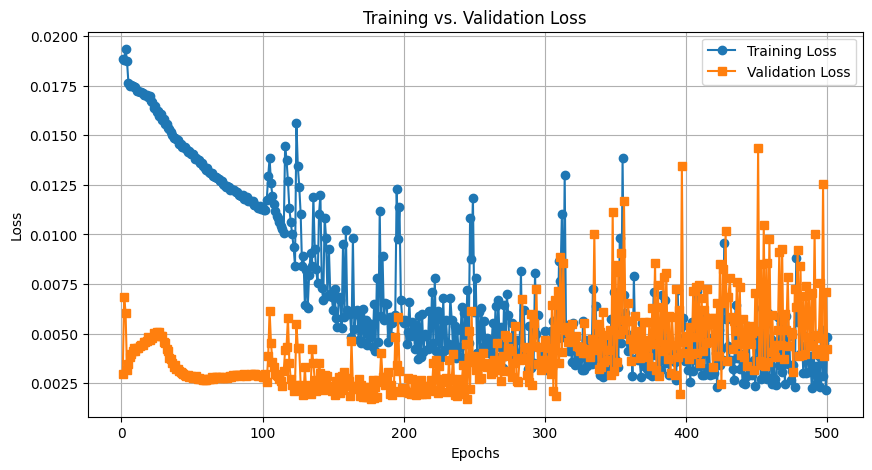

In [71]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


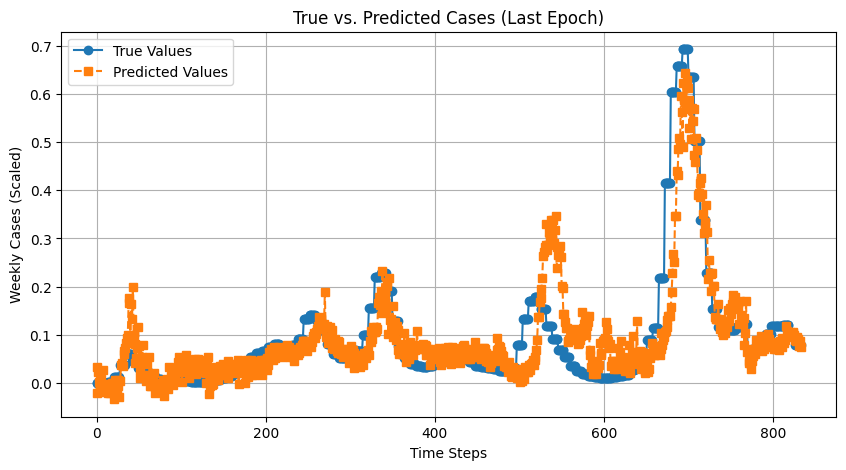

In [73]:
# Convert lists to NumPy arrays for easier manipulation
predictions_last = np.array(predictions_last).flatten()  # Flatten to 1D
actuals_last = np.array(actuals_last).flatten()

# Plot True vs Predicted Values
plt.figure(figsize=(10, 5))
plt.plot(actuals_last, label="True Values", marker="o")
plt.plot(predictions_last, label="Predicted Values", marker="s", linestyle="dashed")
plt.xlabel("Time Steps")
plt.ylabel("Weekly Cases (Scaled)")
plt.title("True vs. Predicted Cases (Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

### Two countries case

#### data

In [1]:
# two_data = model_data.loc[model_data.location.isin(['Spain', 'United States'])]
two_data = two_data[['location', 'C', 'E', 'G', 'S', 'weekly_deaths', 'weekly_cases']]

fig = px.line(two_data, x=two_data.index, y='weekly_cases', title='Weekly Cases in Spain')
fig.update_layout(width=600, height=300)  # Set width to 600px and height to 300px
fig.show()

NameError: name 'two_data' is not defined

In [66]:
def create_sequences_per_country(df, countries, feature_columns, seq_length):
    X_list, y_list = [], []

    for country in countries:
        country_data = df[df["location"] == country].drop(columns=["location"]).reset_index(drop=True)
        features = country_data[feature_columns].values
        target = country_data["new_cases"].values

        X, y = [], []
        for i in range(len(features) - seq_length):
            X.append(features[i : i + seq_length])
            y.append(target[i + seq_length])

        X_list.append(np.array(X))
        y_list.append(np.array(y))

    return np.vstack(X_list), np.hstack(y_list)

In [81]:
from typing import Tuple, Union, Type
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale_data_per_country(df: pd.DataFrame, countries: list, feature_columns: list, target_column: str,
                           scaler: Union[Type[MinMaxScaler], Type[StandardScaler]], seq_length: int = 30) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Scales the feature and target columns separately for each country using the specified scaler
    and prepares the data for sequence modeling.

    Args:
        df (pd.DataFrame): The input DataFrame containing location, features, and target column.
        countries (list): List of country names to process separately.
        feature_columns (list): List of feature column names to be scaled.
        target_column (str): Name of the target column to be scaled.
        scaler (Union[Type[MinMaxScaler], Type[StandardScaler]]): The scaler class to be used for normalization.
        seq_length (int): The sequence length for LSTM input.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: A tuple containing:
            - y_train (np.ndarray): Target values for the training set.
            - y_test (np.ndarray): Target values for the test set.
            - X_train (np.ndarray): Scaled feature sequences for the training set.
            - X_test (np.ndarray): Scaled feature sequences for the test set.
    """

    X_list, y_list = [], []

    for country in countries:
        # Filter data per country
        country_data = df[df["location"] == country].drop(columns=["location"]).reset_index(drop=True)

        # Apply separate scalers per country
        scaler_X = scaler
        scaler_y = scaler

        # Scale features and target separately
        features_scaled = scaler_X.fit_transform(country_data[feature_columns])
        target_scaled = scaler_y.fit_transform(country_data[target_column].values.reshape(-1, 1))

        # Convert back to DataFrame
        scaled_features_df = pd.DataFrame(features_scaled, columns=feature_columns)
        scaled_target_df = pd.DataFrame(target_scaled, columns=[target_column])

        # Merge back
        scaled_data = pd.concat([scaled_features_df, scaled_target_df], axis=1)

        # Create sequences using the scaled data
        X, y = create_sequences(scaled_data, target_column, feature_columns, seq_length)

        X_list.append(X)
        y_list.append(y)

    # Combine sequences from all countries
    X_all = np.vstack(X_list)
    y_all = np.hstack(y_list)

    # Train-test split
    train_size = int(len(X_all) * 0.9)
    X_train, X_test = X_all[:train_size], X_all[train_size:]
    y_train, y_test = y_all[:train_size], y_all[train_size:]

    print("Training data shape:", X_train.shape, y_train.shape)
    print("Testing data shape:", X_test.shape, y_test.shape)

    return y_train, y_test, X_train, X_test


In [82]:
feature_columns = ['C', 'E', 'G', 'S', 'weekly_deaths']#, 'weekly_cases']  # Update with actual feature names
target_column = "weekly_cases"


# Initialize scaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

y_train, y_test, X_train, X_test = scale_data_per_country(df=two_data, feature_columns=feature_columns,
                                    countries=list(two_data['location'].unique()), target_column=target_column, scaler=MinMaxScaler())


Training data shape: (1880, 30, 5) (1880,)
Testing data shape: (209, 30, 5) (209,)


#### training

In [83]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size= X_train.shape[2]
hidden_size=100
num_layers= 2
output_size=1
# Define model
model = StackedLSTM(input_size=input_size, hidden_size=hidden_size,
                    num_layers=num_layers, output_size=output_size).to(device)
model.apply(init_weights)
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

print(device)
print(model)  # Print model architecture


cuda
StackedLSTM(
  (lstm): LSTM(5, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


In [84]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1).to(device)

# Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##### training loop

In [85]:
import matplotlib.pyplot as plt

# Initialize training parameters
num_epochs = 500  # Adjust as needed
print_every = 20  # Set how often to print

# Store losses
train_losses = []
val_losses = []

# Start training
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0

    # Only keep predictions and inputs from the last epoch
    if epoch == num_epochs - 1:
        predictions_last = []
        actuals_last = []
        inputs_last = []

    # Training loop
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()  # Zero gradients
        y_pred = model(X_batch)  # Forward pass

        loss = criterion(y_pred, y_batch)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        train_loss += loss.item()  # Accumulate training loss

        # Store predictions, actuals, and inputs only for the last epoch
        if epoch == num_epochs - 1:
            predictions_last.extend(y_pred.cpu().detach().numpy())
            actuals_last.extend(y_batch.cpu().numpy())
            inputs_last.extend(X_batch.cpu().numpy())

    # Compute average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop using test set
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():
        for i in range(len(X_test)):  # Iterate through test set
            X_val, y_val = X_test_tensor[i].to(device), y_test_tensor[i].to(device)
            y_val_pred = model(X_val.unsqueeze(0))  # Add batch dimension
            loss = criterion(y_val_pred, y_val.unsqueeze(0))
            val_loss += loss.item()

    avg_val_loss = val_loss / len(X_test)
    val_losses.append(avg_val_loss)

    # Print the loss every 'print_every' epochs
    if (epoch + 1) % print_every == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss (Test Set): {avg_val_loss:.4f}")


Epoch [20/500] - Train Loss: 0.0258, Val Loss (Test Set): 0.0024
Epoch [40/500] - Train Loss: 0.0231, Val Loss (Test Set): 0.0040
Epoch [60/500] - Train Loss: 0.0208, Val Loss (Test Set): 0.0033
Epoch [80/500] - Train Loss: 0.0182, Val Loss (Test Set): 0.0066
Epoch [100/500] - Train Loss: 0.0206, Val Loss (Test Set): 0.0042
Epoch [120/500] - Train Loss: 0.0094, Val Loss (Test Set): 0.0060
Epoch [140/500] - Train Loss: 0.0090, Val Loss (Test Set): 0.0064
Epoch [160/500] - Train Loss: 0.0082, Val Loss (Test Set): 0.0040
Epoch [180/500] - Train Loss: 0.0071, Val Loss (Test Set): 0.0047
Epoch [200/500] - Train Loss: 0.0095, Val Loss (Test Set): 0.0072
Epoch [220/500] - Train Loss: 0.0086, Val Loss (Test Set): 0.0049
Epoch [240/500] - Train Loss: 0.0076, Val Loss (Test Set): 0.0043
Epoch [260/500] - Train Loss: 0.0089, Val Loss (Test Set): 0.0052
Epoch [280/500] - Train Loss: 0.0047, Val Loss (Test Set): 0.0038
Epoch [300/500] - Train Loss: 0.0072, Val Loss (Test Set): 0.0046
Epoch [320/500

##### Training visualization

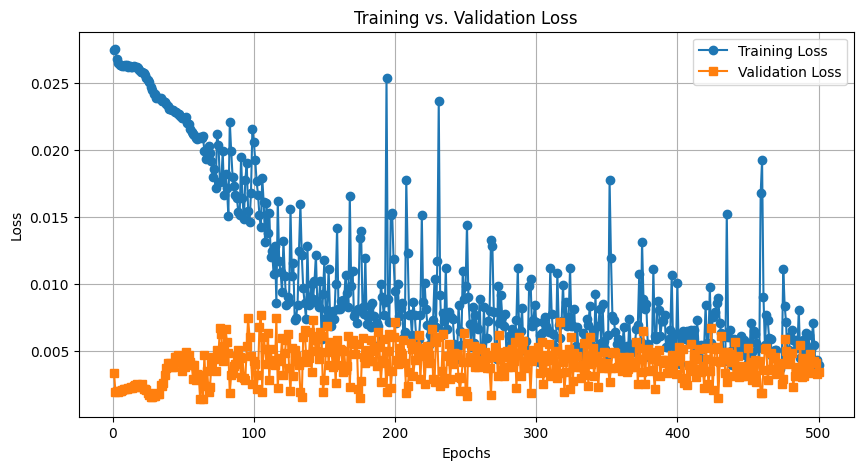

In [86]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


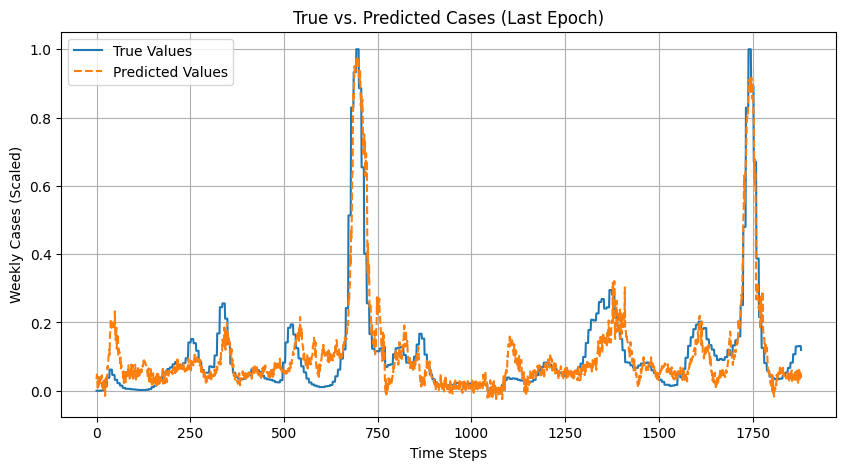

In [90]:
# Convert lists to NumPy arrays for easier manipulation
predictions_last = np.array(predictions_last).flatten()  # Flatten to 1D
actuals_last = np.array(actuals_last).flatten()

# Plot True vs Predicted Values
plt.figure(figsize=(10, 5))
plt.plot(actuals_last, label="True Values")
plt.plot(predictions_last, label="Predicted Values", linestyle="dashed")
plt.xlabel("Time Steps")
plt.ylabel("Weekly Cases (Scaled)")
plt.title("True vs. Predicted Cases (Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()